# Logistic Regression

In this exercise, you will implement logistic regression and apply it to two different datasets. 


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Logistic Regression](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2 Loading and visualizing the data](#2.2)
  - [ 2.3  Sigmoid function](#2.3)
  - [ 2.4 Cost function for logistic regression](#2.4)
  - [ 2.5 Gradient for logistic regression](#2.5)
  - [ 2.6 Learning parameters using gradient descent ](#2.6)
  - [ 2.7 Plotting the decision boundary](#2.7)
  - [ 2.8 Evaluating logistic regression](#2.8)
- [ 3 - Regularized Logistic Regression](#3)
  - [ 3.1 Problem Statement](#3.1)
  - [ 3.2 Loading and visualizing the data](#3.2)
  - [ 3.3 Feature mapping](#3.3)
  - [ 3.4 Cost function for regularized logistic regression](#3.4)
  - [ 3.5 Gradient for regularized logistic regression](#3.5)
  - [ 3.6 Learning parameters using gradient descent](#3.6)
  - [ 3.7 Plotting the decision boundary](#3.7)
  - [ 3.8 Evaluating regularized logistic regression model](#3.8)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [30]:
import math, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from public_tests import *
#%matplotlib inline

<a name="2"></a>
## 2 - Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

<a name="2.1"></a>
### 2.1 Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, you have the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

<a name="2.2"></a>
### 2.2 Loading and visualizing the data

You will start by loading the dataset for this task. 
- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision 
      - `y_train = 1` if the student was admitted 
      - `y_train = 0` if the student was not admitted 
  - Both `X_train` and `y_train` are numpy arrays.


In [31]:
# load dataset
def load_data(filename):
    """
    从CSV文件加载数据集
    参数:
        filename (str): 数据文件绝对路径
    返回:
        X (ndarray): (m, n) 特征矩阵 
        y (ndarray): (m,) 目标向量
    """
    data = pd.read_csv(filename, header=None, names=['x_1', 'x_2', 'y'])
    X = data.iloc[:, :-1].values  # 前n列为特征
    y = data.iloc[:, -1].values   # 最后一列为目标值
    return X, y, data

In [32]:
X_train, y_train, data= load_data("./data/ex2data1.txt")

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five values of `X_train` and the type of the variable.

In [33]:
data.head()

,x_1,x_2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Now print the first five values of `y_train`

In [34]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0 0 0 1 1]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [35]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


#### Visualize your data
Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [36]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    # 绘制正类样本,也就是y为1的特征
    plt.plot(X[positive, 0], X[positive, 1], 'r+', label=pos_label)
    # 绘制负类样本,也就是y为0的特征
    plt.plot(X[negative, 0], X[negative, 1], 'bo', label=neg_label)

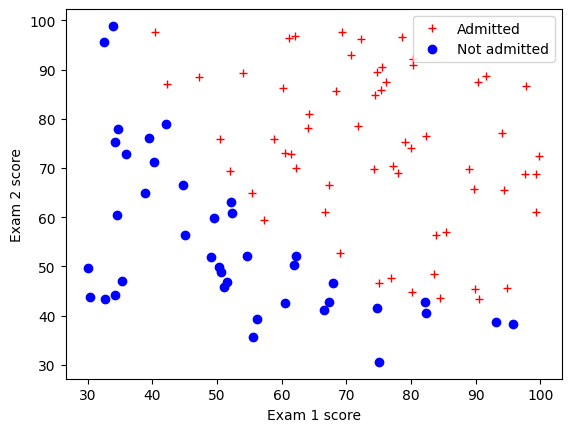

In [37]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")
plt.show()

Your goal is to build a logistic regression model to fit this data.
- With this model, you can then predict if a new student will be admitted based on their scores on the two exams.

<a name="2.3"></a>
### 2.3  Sigmoid function

Recall that for logistic regression, map the linear combination to the interval [0,1], the model is represented as
$$
\begin{align*}
P(y=1 \mid \mathbf{x}) = f_{\mathbf{w},b}(x)
&= \hat{y} \\
& = \sigma(\mathbf{w}\cdot \mathbf{x} + b)
\tag{2-3-1}
\end{align*} 
$$

where function $\sigma(z)$ is the sigmoid function. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1+e^{-z}} \tag{2-3-2}
$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.

Note that 
- `z` is not always a single number, but can also be an array of numbers. 
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [38]:
# UNQ_C1
# GRADED FUNCTION: sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    # 限制z的大小在指定范围内
    # z = np.clip(z, -500, 500)           # protect against overflow
          
    ### START CODE HERE ### 
    g = 1 / (1 + np.exp(-z))
    ### END SOLUTION ###  
    
    return g

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
       
`numpy` has a function called [`np.exp()`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html), which offers a convinient way to calculate the exponential ( $e^{z}$) of all elements in the input array (`z`).
 
<details>
          <summary><font size="2" color="darkblue"><b> Click for more hints</b></font></summary>
        
  - You can translate $e^{-z}$ into code as `np.exp(-z)` 
    
  - You can translate $1/e^{-z}$ into code as `1/np.exp(-z)` 
    
    If you're still stuck, you can check the hints presented below to figure out how to calculate `g` 
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate g</b></font></summary>
        <code>g = 1 / (1 + np.exp(-z))</code>
    </details>


</details>

When you are finished, try testing a few values by calling `sigmoid(x)` in the cell below. 
- For large positive values of x, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. 
- Evaluating `sigmoid(0)` should give you exactly 0.5. 


In [39]:
print ("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


**Draw Draw the image of sigmod**

In [40]:
# Generate an array of evenly spaced values between -10 and 10
z_tmp = np.arange(-10,11)
z_tmp.shape

(21,)

In [41]:
# Use the function implemented above to get the sigmoid values
y_test = sigmoid(z_tmp)
y_test.shape

(21,)

In [42]:
# Code for pretty printing the two arrays next to each other
np.set_printoptions(precision=3) 
print("Input (z), Output (sigmoid(z))")
print(np.c_[z_tmp, y_test])

Input (z), Output (sigmoid(z))
[[-1.000e+01  4.540e-05]
 [-9.000e+00  1.234e-04]
 [-8.000e+00  3.354e-04]
 [-7.000e+00  9.111e-04]
 [-6.000e+00  2.473e-03]
 [-5.000e+00  6.693e-03]
 [-4.000e+00  1.799e-02]
 [-3.000e+00  4.743e-02]
 [-2.000e+00  1.192e-01]
 [-1.000e+00  2.689e-01]
 [ 0.000e+00  5.000e-01]
 [ 1.000e+00  7.311e-01]
 [ 2.000e+00  8.808e-01]
 [ 3.000e+00  9.526e-01]
 [ 4.000e+00  9.820e-01]
 [ 5.000e+00  9.933e-01]
 [ 6.000e+00  9.975e-01]
 [ 7.000e+00  9.991e-01]
 [ 8.000e+00  9.997e-01]
 [ 9.000e+00  9.999e-01]
 [ 1.000e+01  1.000e+00]]


In [43]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

# Draws a threshold at 0.5
def draw_vthresh(ax, x):
    """ draws a threshold """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], x], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
    ax.fill_between([x, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
    ax.annotate("z >= 0", xy= [x,0.5], xycoords='data',
                xytext=[30,5],textcoords='offset points')
    d = FancyArrowPatch(
        posA=(x, 0.5), posB=(x+3, 0.5), color=dldarkred,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(d)
    ax.annotate("z < 0", xy= [x,0.5], xycoords='data',
                 xytext=[-50,5],textcoords='offset points', ha='left')
    f = FancyArrowPatch(
        posA=(x, 0.5), posB=(x-3, 0.5), color=dlblue,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(f)

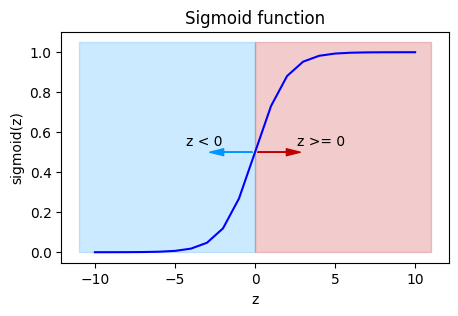

In [44]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z_tmp, y_test, c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')

draw_vthresh(ax, 0)

 - It can be seen that the output of the sigmoid function is always within the range of (0, 1]

### 2.4 Cost function for logistic regression

#### 2.4.1 Parameter estimation: Maximum likelihood estimation

假设有m个样本，每个样本是一个特征向量$\mathbf{x}_i$和对应的目标值$y_i$ 
$$
\left\{ (\mathbf{x}_i, y_i) \right\}_{i=1}^m, \quad \mathbf{x}_i \in \mathbb{R}^d,\ y_i \in \{0, 1\}
$$
希望找到最优的$\mathbf{w}$ 和 $b$ 使得训练数据在模型(2-3-1~2-3-2)出现的可能性最大,这就是极大似然估计的核心思想,用观测值估计最佳的模型参数

每个样本的概率为：
$$
P(y_i \mid \mathbf{x}_i; \mathbf{w}, b) = \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i}
$$
- 当$y_i=1$时，概率是$\hat{y}_i$
- 当当$y_i=0$时，概率是$1 - \hat{y}_i$

所有样本的联合概率（似然）为：
$$
L(\boldsymbol{\mathbf{w}, b}) = \prod_{i=1}^m \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i}
\tag{2-4-1}
$$
- 其中L为likelihood的缩写

对似然函数取对数(标量形式)：
$$
\log L(\boldsymbol{\mathbf{w}, b}) = \sum_{i=1}^m \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]
\tag{2-4-2}
$$

对似然函数取对数(矩阵形式)：
$$
\log L(\boldsymbol{\mathbf{w}, b}) = \mathbf{y}^T \log \hat{\mathbf{y}} + (1 - \mathbf{y})^T \log(1 - \hat{\mathbf{y}})
\tag{2-4-3}
$$

损失函数（负对数似然 = 交叉熵）（标量形式）：
$$
\mathcal{L}(\boldsymbol{\mathbf{w}, b}) = -\log L(\boldsymbol{\mathbf{w}, b}) = - \sum_{i=1}^m \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]
\tag{2-4-4}
$$
损失函数（负对数似然 = 交叉熵）（矩阵形式）：
$$
\mathcal{L}(\boldsymbol{\mathbf{w}, b}) = - \left[ \mathbf{y}^T \log \hat{\mathbf{y}} + (1 - \mathbf{y})^T \log(1 - \hat{\mathbf{y}}) \right]
\tag{2-4-5}
$$

<a name="2.4"></a>
#### 2.4.2 COST FUNTION
In this section, you will implement the cost function for logistic regression.
Recall that for logistic regression, the cost function is of the form 

$$ 
J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(\hat{y_i}, y_i) \right] 
\tag{2-4-6}
$$

Maximizing log-likelihood is equivalent to minimizing cross-entropy loss depend on 2-4-4:
$$
\begin{align*}
J(\mathbf{w},b) 
&= \frac{1}{m} \mathcal{L}(\boldsymbol{\mathbf{w}, b}) \\
&= -\frac{1}{m} \sum_{i=1}^m \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]
\end{align*} 
\tag{2-4-7}
$$
2-6 Matrix form：
$$
J(\mathbf{w},b) = -\frac{1}{m} \left[ \mathbf{y}^T \log(\mathbf{\hat{y}}) + (\mathbf{1} - \mathbf{y})^T \log(\mathbf{1} - \mathbf{\hat{y}}) \right]
\tag{2-4-8}
$$
where
* m is the number of training examples in the dataset


* $loss(\hat{y_i}, y_i)$ is the cost for a single data point, which is - 

$$
\begin{align}
loss({i}) &= loss(\hat{y_i}, y_i) \nonumber \\
       &= -y_i \log \hat{y}_i - (1 - y_i) \log (1 - \hat{y}_i) 
\tag{2-4-9}
\end{align}
$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}_i)$ is the model's prediction, while $y_i$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}_i) = \sigma(\mathbf{w} \cdot \mathbf{x_i} + b)$ where function $\sigma$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}_i) = \mathbf{w} \cdot \mathbf{x_i} + b = w^0x^{(0)}_i + ... + w^{n-1}x^{(n-1)}_i + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}_i) = \sigma(z_{\mathbf{w},b}(\mathbf{x}_i))$

Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [47]:
# UNQ_C2
# GRADED FUNCTION: compute_cost from 2-4-6
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    ### START CODE HERE ###
    # shape (m,)
    z = X @ w + b
    # shape (m,)
    y_hat = sigmoid(z)
    # 将 y_hat 限制在 [1e-15, 1-1e-15] 防止溢出
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)  
    # 最后得到的是个标量  (-1 / m) * [((1,m) @ (m,1)) + (1, m) @ (m, 1)]
    total_cost = (-1 / m) * (y.T @ np.log(y_hat) + (1 - y).T @ np.log(1 - y_hat))
    ### END CODE HERE ### 
    return total_cost

In [48]:
X_train.shape

(100, 2)

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
   * You can represent a summation operator eg: $h = \sum\limits_{i = 0}^{m-1} 2i$ in code as follows:
    ```python 
        h = 0
        for i in range(m):
            h = h + 2*i
    ```
  
   * In this case, you can iterate over all the examples in `X` using a for loop and add the `loss` from each iteration to a variable (`loss_sum`) initialized outside the loop.

   * Then, you can return the `total_cost` as `loss_sum` divided by `m`.
     
    <details>
          <summary><font size="2" color="darkblue"><b> Click for more hints</b></font></summary>
        
    * Here's how you can structure the overall implementation for this function
    ```python 
    def compute_cost(X, y, w, b, lambda_= 1):
        m, n = X.shape
    
        ### START CODE HERE ###
        loss_sum = 0 
        
        # Loop over each training example
        for i in range(m): 
            
            # First calculate z_wb = w[0]*X[i][0]+...+w[n-1]*X[i][n-1]+b
            z_wb = 0 
            # Loop over each feature
            for j in range(n): 
                # Add the corresponding term to z_wb
                z_wb_ij = # Your code here to calculate w[j] * X[i][j]
                z_wb += z_wb_ij # equivalent to z_wb = z_wb + z_wb_ij
            # Add the bias term to z_wb
            z_wb += b # equivalent to z_wb = z_wb + b
        
            f_wb = # Your code here to calculate prediction f_wb for a training example
            loss =  # Your code here to calculate loss for a training example
            
            loss_sum += loss # equivalent to loss_sum = loss_sum + loss
        
        total_cost = (1 / m) * loss_sum  
        ### END CODE HERE ### 
        
        return total_cost
    ```
    
    If you're still stuck, you can check the hints presented below to figure out how to calculate `z_wb_ij`, `f_wb` and `cost`.
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate z_wb_ij</b></font></summary>
           &emsp; &emsp; <code>z_wb_ij = w[j]*X[i][j] </code>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$ where $g$ is the sigmoid function. You can simply call the `sigmoid` function implemented above.
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f</b></font></summary>
               &emsp; &emsp; You can compute f_wb as <code>f_wb = sigmoid(z_wb) </code>
           </details>
    </details>

     <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate loss</b></font></summary>
          &emsp; &emsp; You can use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.log.html">np.log</a> function to calculate the log
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate loss</b></font></summary>
              &emsp; &emsp; You can compute loss as <code>loss =  -y[i] * np.log(f_wb) - (1 - y[i]) * np.log(1 - f_wb)</code>
          </details>
    </details>
        
    </details>

</details>

Run the cells below to check your implementation of the `compute_cost` function with two different initializations of the parameters $w$

In [49]:
m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
# initial_w = np.array([0.2, 0.2])
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


**Expected Output**:
<table>
  <tr>
    <td> <b>Cost at initial w (zeros)<b></td>
    <td> 0.693 </td> 
  </tr>
</table>

In [51]:
# Compute and display cost with non-zero w
test_w = np.array([0.2, 0.2])
test_b = -24.
cost = compute_cost(X_train, y_train, test_w, test_b)

print('Cost at test w,b: {:.3f}'.format(cost))


# UNIT TESTS
compute_cost_test(compute_cost)


Cost at test w,b: 0.218
All tests passed!


**Expected Output**:
<table>
  <tr>
    <td> <b>Cost at test w,b<b></td>
    <td> 0.218 </td> 
  </tr>
</table>

<a name="2.5"></a>
### 2.5 Gradient for logistic regression

#### 2.5.1 求导推导

根据公式2-4-9对于单个样本i损失函数$loss({i})$对权重参数$w_j$的偏导数为(使用链式法则)：
$$
\frac{\partial loss({i})}{\partial w_j} = \frac{\partial loss({i})}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial z_i} \cdot \frac{\partial z_i}{\partial w_j} 
\tag{2-5-1}
$$

**$loss({i})$ 对$\hat{y}_i$求导**=>
$$
\frac{\partial loss({i})}{\partial \hat{y}_i} = \frac{y_i}{\hat{y}_i} - \frac{1 - y_i}{1 - \hat{y}_i} 
\tag{2-5-2}
$$

**$\hat{y}_i$对$z$求导=>**

- (1)Sigmoid函数的定义
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

$$
\begin{align}
\frac{\partial \sigma(z)}{\partial z} 
= \frac{d}{dz} \left( \frac{1}{1 + e^{-z}} \right)
= \frac{0 \cdot (1 + e^{-z}) - 1 \cdot (-e^{-z})}{(1 + e^{-z})^2} 
\end{align}
\tag{2-5-3}
$$

- (2)简化分子得到：
$$
\begin{align}
\frac{\partial \sigma(z)}{\partial z} = \frac{e^{-z}}{(1 + e^{-z})^2}
\end{align}
\tag{2-5-4}
$$

- (3)观察分子和分母的关系，可将（3）式分解：
$$
\frac{e^{-z}}{(1 + e^{-z})^2} 
= \frac{1}{1 + e^{-z}} \cdot \frac{e^{-z}}{1 + e^{-z}} 
= \sigma(z) \cdot \left( 1 - \sigma(z) \right)
\tag{2-5-5}
$$

- (4)关键步骤解释：
    - a). 分解分子：$e^{-z} = (1 + e^{-z}) - 1$。
    - b). 代入 $\sigma(z) = \frac{1}{1 + e^{-z}}$，则：
$$
\frac{e^{-z}}{1 + e^{-z}} = 1 - \frac{1}{1 + e^{-z}} = 1 - \sigma(z)
\tag{2-5-6}
$$

- (5)最终结果并对应到逻辑回归中：
$$
\begin{align}
\frac{\partial \hat{y}_i}{\partial z_i} &= \frac{\partial \sigma(z)}{\partial z} \\
                                        &= \sigma(z)(1 - \sigma(z)) \\
                                        &= \hat{y}_i (1 - \hat{y}_i) 
\end{align}
\tag{2-5-7}
$$

**线性项对权重的偏导数=>**
- 对于单个样本 $i$，线性项 $z_i$ 定义为权重向量 $\mathbf{w}$ 与特征向量 $\mathbf{x}_i$ 的点积加上偏置项 $b$：
$$
z_i = \mathbf{w} \cdot \mathbf{x}_i + b = \sum_{k=1}^n w_k x_{ik} + b \tag{2-5-8}
$$

- 对 $w_j$ 求偏导时，只有第 $j$ 项权重 $w_j$ 和对应的特征值 $x_{ij}$ 会对结果产生贡献，其余项（如 $w_k$ 或 $b$）的导数为零。因此：
$$
\frac{\partial z_i}{\partial w_j} = \frac{\partial}{\partial w_j} \left( \sum_{k=1}^n w_k x_{ik} + b \right) = x_{ij} \tag{2-5-9}
$$

**链式法则合并结果将2-5-2,2-5-7,2-5-9代入到2-5-1并进行化简：**
$$
\frac{\partial loss({i})}{\partial w_j} = \left( \frac{y_i}{\hat{y}_i} - \frac{1 - y_i}{1 - \hat{y}_i} \right) \cdot \hat{y}_i (1 - \hat{y}_i) \cdot x_{ij} = (y_i - \hat{y}_i) x_{ij} \tag{2-5-10}
$$

**对所有样本求平均得到$J(\mathbf{w},b)$对$w_j$的导数:**
$$
\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i - y_i) x_{ij} \tag{2-5-11}
$$
**用矩阵方式表示：**
$$
\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m} \mathbf{X}^T (\mathbf{\hat{y}} - \mathbf{y}) \tag{2-5-12}
$$

**偏置项梯度**
- 推导过程和上述对权重参数求偏导的过程一致
- 不同点是在2-5-8求偏导的过程中因为是对b求偏导,所有的出来的导数为1
- 从而有：
$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i - y_i) \tag{2-5-13}
$$

**用矩阵形式表示：**
$$
\frac{\partial J}{\partial b} = \frac{1}{m} \mathbf{1}^T (\mathbf{\hat{y}} - \mathbf{y}) \tag{2-5-14}
$$

#### 2.5.2 gradient descent algorithm

In this section, you will implement the gradient for logistic regression.
Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{2-5-15}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously


<a name='ex-03'></a>
### Exercise 3

Please complete the `compute_gradient` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2-5-13}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{2-5-11}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.

As before, you can use the sigmoid function that you implemented above and if you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [52]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient from 2-5-12 and 2-5-14
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    # shape (m,)
    z = X @ w + b
    # shape (m,)
    y_hat = sigmoid(z)
    # 将 y_hat 限制在 [1e-15, 1-1e-15] 防止溢出
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)  
    
    # 构造全1行向量 (m)
    ones_vec = np.ones((m))  
    dj_db = (ones_vec.T @ (y_hat - y)) / m

    # (n,m) @ (m,) 
    dj_dw = (X.T @ (y_hat - y)) / m
    
    ### END CODE HERE ###
    
    return dj_db, dj_dw

 <details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* Here's how you can structure the overall implementation for this function
    ```python 
       def compute_gradient(X, y, w, b, lambda_=None): 
            m, n = X.shape
            dj_dw = np.zeros(w.shape)
            dj_db = 0.
        
            ### START CODE HERE ### 
            err  = 0.
            for i in range(m):
                # Calculate f_wb (exactly as you did in the compute_cost function above)
                f_wb = 
        
                # Calculate the  gradient for b from this example
                dj_db_i = # Your code here to calculate the error
        
                # add that to dj_db
                dj_db += dj_db_i
        
                # get dj_dw for each attribute
                for j in range(n):
                    # You code here to calculate the gradient from the i-th example for j-th attribute
                    dj_dw_ij =  
                    dj_dw[j] += dj_dw_ij
        
            # divide dj_db and dj_dw by total number of examples
            dj_dw = dj_dw / m
            dj_db = dj_db / m
            ### END CODE HERE ###
       
            return dj_db, dj_dw
    ```
  
    If you're still stuck, you can check the hints presented below to figure out how to calculate `f_wb`, `dj_db_i` and `dj_dw_ij` 
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; Recall that you calculated f_wb in <code>compute_cost</code> above — for detailed hints on how to calculate each intermediate term, check out the hints section below that exercise
           <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f_wb</b></font></summary>
              &emsp; &emsp; You can calculate f_wb as
               <pre>
               for i in range(m):   
                   # Calculate f_wb (exactly how you did it in the compute_cost function above)
                   z_wb = 0
                   # Loop over each feature
                   for j in range(n): 
                       # Add the corresponding term to z_wb
                       z_wb_ij = X[i, j] * w[j]
                       z_wb += z_wb_ij
            
                   # Add bias term 
                   z_wb += b
        
                   # Calculate the prediction from the model
                   f_wb = sigmoid(z_wb)
    </details>
        
    </details>
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_db_i</b></font></summary>
           &emsp; &emsp; You can calculate dj_db_i as <code>dj_db_i = f_wb - y[i]</code>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_dw_ij</b></font></summary>
        &emsp; &emsp; You can calculate dj_dw_ij as <code>dj_dw_ij = (f_wb - y[i])* X[i][j]</code>
    </details>

</details>

Run the cells below to check your implementation of the `compute_gradient` function with two different initializations of the parameters $w$

In [53]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.009216589291151, -11.262842205513593]


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db at initial w (zeros)<b></td>
    <td> -0.1 </td> 
  </tr>
  <tr>
    <td> <b>ddj_dw at initial w (zeros):<b></td>
    <td> [-12.00921658929115, -11.262842205513591] </td> 
  </tr>
</table>

In [54]:
# Compute and display cost and gradient with non-zero w
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db at test_w:', dj_db)
print('dj_dw at test_w:', dj_dw.tolist())

# UNIT TESTS    
compute_gradient_test(compute_gradient)

dj_db at test_w: -0.5999999999991065
dj_dw at test_w: [-44.83135361787374, -44.37384124953973]
All tests passed!


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db at initial w (zeros)<b></td>
    <td> -0.5999999999991071 </td> 
  </tr>
  <tr>
    <td> <b>ddj_dw at initial w (zeros):<b></td>
    <td>  [-44.8313536178737957, -44.37384124953978] </td> 
  </tr>
</table>

<a name="2.6"></a>
### 2.6 Learning parameters using gradient descent 

Similar to the previous assignment, you will now find the optimal parameters of a logistic regression model by using gradient descent. 
- You don't need to implement anything for this part. Simply run the cells below. 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

- Assuming you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [55]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = X.shape[0]
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

**Note**

The code block below takes a couple of minutes to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, try running 100,000 iterations for better results.

In [56]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


<details>
<summary>
    <b>Expected Output: Cost     0.30, (Click to see details):</b>
</summary>

    # With the following settings
    np.random.seed(1)
    intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
    initial_b = -8
    iterations = 10000
    alpha = 0.001
    #

```
Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   
```

<a name="2.7"></a>
### 2.7 Plotting the decision boundary

We will now use the final parameters from gradient descent to plot the linear fit. If you implemented the previous parts correctly, you should see the following plot:   
<img src="images/figure 2.png"  width="450" height="450">

We will use a helper function in the `utils.py` file to create this plot.

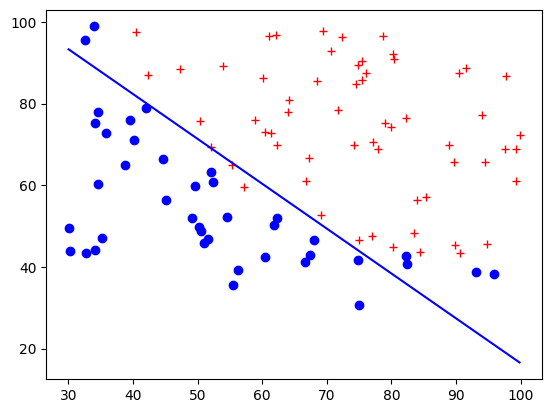

In [57]:
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_data(X[:, 0:2], y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

plot_decision_boundary(w, b, X_train, y_train)

<a name="2.8"></a>
### 2.8 Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

You will implement the `predict` function below to do this.


<a name='ex-04'></a>
### Exercise 4

Please complete the `predict` function to produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example 
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$
    
If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [60]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    for i in range(m):
        z_wb = 0
        # 对每一列特征计算z_wb_ij,然后加起来
        # 就等于每一行的z_wb
        for j in range(n):
            z_wb_ij = X[i, j] * w[j]
            z_wb += z_wb_ij
        # 加上偏置,就得到每一行(每一个样本)的z_wb的预测值
        z_wb += b
        
        f_wb = sigmoid(z_wb)

        if (f_wb >= 0.5):
            p[i] = 1
        else:
            p[i] = 0
    ### END CODE HERE ### 
    return p

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* Here's how you can structure the overall implementation for this function
    ```python 
       def predict(X, w, b): 
            # number of training examples
            m, n = X.shape   
            p = np.zeros(m)
   
            ### START CODE HERE ### 
            # Loop over each example
            for i in range(m):   
                
                # Calculate f_wb (exactly how you did it in the compute_cost function above) 
                # using a couple of lines of code
                f_wb = 

                # Calculate the prediction for that training example 
                p[i] = # Your code here to calculate the prediction based on f_wb
        
            ### END CODE HERE ### 
            return p
    ```
  
    If you're still stuck, you can check the hints presented below to figure out how to calculate `f_wb` and `p[i]` 
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate f_wb</b></font></summary>
           &emsp; &emsp; Recall that you calculated f_wb in <code>compute_cost</code> above — for detailed hints on how to calculate each intermediate term, check out the hints section below that exercise
           <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate f_wb</b></font></summary>
              &emsp; &emsp; You can calculate f_wb as
               <pre>
               for i in range(m):   
                   # Calculate f_wb (exactly how you did it in the compute_cost function above)
                   z_wb = 0
                   # Loop over each feature
                   for j in range(n): 
                       # Add the corresponding term to z_wb
                       z_wb_ij = X[i, j] * w[j]
                       z_wb += z_wb_ij
            
                   # Add bias term 
                   z_wb += b
        
                   # Calculate the prediction from the model
                   f_wb = sigmoid(z_wb)
    </details>
        
    </details>
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate p[i]</b></font></summary>
           &emsp; &emsp; As an example, if you'd like to say x = 1 if y is less than 3 and 0 otherwise, you can express it in code as <code>x = y < 3 </code>. Now do the same for p[i] = 1 if f_wb >= 0.5 and 0 otherwise. 
           <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate p[i]</b></font></summary>
              &emsp; &emsp; You can compute p[i] as <code>p[i] = f_wb >= 0.5</code>
          </details>
    </details>

</details>

Once you have completed the function `predict`, let's run the code below to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [61]:
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

# UNIT TESTS        
predict_test(predict)

Output of predict: shape (4,), value [0. 1. 1. 1.]
All tests passed!


**Expected output** 

<table>
  <tr>
    <td> <b>Output of predict: shape (4,),value [0. 1. 1. 1.]<b></td>
  </tr>
</table>

Now let's use this to compute the accuracy on the training set

In [63]:
#Compute accuracy on our training set
p = predict(X_train, w, b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


<table>
  <tr>
    <td> <b>Train Accuracy (approx):<b></td>
    <td> 92.00 </td> 
  </tr>
</table>

<a name="3"></a>
## 3 - Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. 

<a name="3.1"></a>
### 3.1 Problem Statement

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. 
- From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
- To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

<a name="3.2"></a>
### 3.2 Loading and visualizing the data

Similar to previous parts of this exercise, let's start by loading the dataset for this task and visualizing it. 

- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains the test results for the microchips from two tests
  - `y_train` contains the results of the QA  
      - `y_train = 1` if the microchip was accepted 
      - `y_train = 0` if the microchip was rejected 
  - Both `X_train` and `y_train` are numpy arrays.

In [ ]:
# load dataset
X_train, y_train = load_data("data/ex2data2.txt")

#### View the variables

The code below prints the first five values of `X_train` and `y_train` and the type of the variables.


In [ ]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [ ]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

#### Visualize your data

The helper function `plot_data` (from `utils.py`) is used to generate a figure like Figure 3, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers.

<img src="images/figure 3.png"  width="450" height="450">

In [ ]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

# Set the y-axis label
plt.ylabel('Microchip Test 2') 
# Set the x-axis label
plt.xlabel('Microchip Test 1') 
plt.legend(loc="upper right")
plt.show()

Figure 3 shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


<a name="3.3"></a>
### 3.3 Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 
- We have provided the `map_feature` function for you in utils.py. 

In [ ]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [ ]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

<a name="3.4"></a>
### 3.4 Cost function for regularized logistic regression

In this part, you will implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization (which you implemented above), which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

<a name='ex-05'></a>
### Exercise 5

Please complete the `compute_cost_reg` function below to calculate the following term for each element in $w$ 
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

The starter code then adds this to the cost without regularization (which you computed above in `compute_cost`) to calculate the cost with regulatization.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [ ]:
# UNQ_C5
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w, b) 
    
    # You need to calculate this value
    reg_cost = 0.
    
    ### START CODE HERE ###
    
        
    ### END CODE HERE ### 
    
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

    return total_cost

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* Here's how you can structure the overall implementation for this function
    ```python 
       def compute_cost_reg(X, y, w, b, lambda_ = 1):
   
           m, n = X.shape
    
            # Calls the compute_cost function that you implemented above
            cost_without_reg = compute_cost(X, y, w, b) 
    
            # You need to calculate this value
            reg_cost = 0.
    
            ### START CODE HERE ###
            for j in range(n):
                reg_cost_j = # Your code here to calculate the cost from w[j]
                reg_cost = reg_cost + reg_cost_j

            ### END CODE HERE ### 
    
            # Add the regularization cost to get the total cost
            total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

        return total_cost
    ```
  
    If you're still stuck, you can check the hints presented below to figure out how to calculate `reg_cost_j` 
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate reg_cost_j</b></font></summary>
           &emsp; &emsp; You can use calculate reg_cost_j as <code>reg_cost_j = w[j]**2 </code> 
    </details>
        
    </details>

</details>

    

Run the cell below to check your implementation of the `compute_cost_reg` function.

In [ ]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

# UNIT TEST    
compute_cost_reg_test(compute_cost_reg)


**Expected Output**:
<table>
  <tr>
    <td> <b>Regularized cost : <b></td>
    <td> 0.6618252552483948 </td> 
  </tr>
</table>

<a name="3.5"></a>
### 3.5 Gradient for regularized logistic regression

In this section, you will implement the gradient for regularized logistic regression.


The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form 
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$


As you can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is $$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$ 





<a name='ex-06'></a>
### Exercise 6

Please complete the `compute_gradient_reg` function below to modify the code below to calculate the following term

$$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

The starter code will add this term to the $\frac{\partial J(\mathbf{w},b)}{\partial w}$ returned from `compute_gradient` above to get the gradient for the regularized cost function.


If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [ ]:
# UNQ_C6
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (ndarray Shape (m,n))   variable such as house size 
      y : (ndarray Shape (m,))    actual value 
      w : (ndarray Shape (n,))    values of parameters of the model      
      b : (scalar)                value of parameter of the model  
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)

    ### START CODE HERE ###     
    
        
    ### END CODE HERE ###         
        
    return dj_db, dj_dw

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
    
* Here's how you can structure the overall implementation for this function
    ```python 
    def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
        m, n = X.shape
    
        dj_db, dj_dw = compute_gradient(X, y, w, b)

        ### START CODE HERE ###     
        # Loop over the elements of w
        for j in range(n): 
            
            dj_dw_j_reg = # Your code here to calculate the regularization term for dj_dw[j]
            
            # Add the regularization term  to the correspoding element of dj_dw
            dj_dw[j] = dj_dw[j] + dj_dw_j_reg
        
        ### END CODE HERE ###         
        
        return dj_db, dj_dw
    ```
  
    If you're still stuck, you can check the hints presented below to figure out how to calculate `dj_dw_j_reg` 
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate dj_dw_j_reg</b></font></summary>
           &emsp; &emsp; You can use calculate dj_dw_j_reg as <code>dj_dw_j_reg = (lambda_ / m) * w[j] </code> 
    </details>
        
    </details>

</details>

    


Run the cell below to check your implementation of the `compute_gradient_reg` function.

In [ ]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

# UNIT TESTS    
compute_gradient_reg_test(compute_gradient_reg)


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db:</b>0.07138288792343656</td> </tr>
  <tr>
      <td> <b> First few elements of regularized dj_dw:</b> </td> </tr>
   <tr>
   <td> [[-0.010386028450548701], [0.01140985288328012], [0.0536273463274574], [0.003140278267313462]] </td> 
  </tr>
</table>

<a name="3.6"></a>
### 3.6 Learning parameters using gradient descent

Similar to the previous parts, you will use your gradient descent function implemented above to learn the optimal parameters $w$,$b$. 
- If you have completed the cost and gradient for regularized logistic regression correctly, you should be able to step through the next cell to learn the parameters $w$. 
- After training our parameters, we will use it to plot the decision boundary. 

**Note**

The code block below takes quite a while to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you hae time, run for 100,000 iterations to see better results.

In [ ]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

<details>
<summary>
    <b>Expected Output: Cost < 0.5  (Click for details)</b>
</summary>

```
# Using the following settings
#np.random.seed(1)
#initial_w = np.random.rand(X_mapped.shape[1])-0.5
#initial_b = 1.
#lambda_ = 0.01;                                          
#iterations = 10000
#alpha = 0.01
Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45       
    
```

<a name="3.7"></a>
### 3.7 Plotting the decision boundary
To help you visualize the model learned by this classifier, we will use our `plot_decision_boundary` function which plots the (non-linear) decision boundary that separates the positive and negative examples. 

- In the function, we plotted the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

- After learning the parameters $w$,$b$, the next step is to plot a decision boundary similar to Figure 4.

<img src="images/figure 4.png"  width="450" height="450">

In [ ]:
plot_decision_boundary(w, b, X_mapped, y_train)

<a name="3.8"></a>
### 3.8 Evaluating regularized logistic regression model

You will use the `predict` function that you implemented above to calculate the accuracy of the regulaized logistic regression model on the training set

In [ ]:
#Compute accuracy on the training set
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

**Expected Output**:
<table>
  <tr>
    <td> <b>Train Accuracy:</b>~ 80%</td> </tr>
</table>